In [5]:
import cv2
from PIL import Image, ImageDraw
import numpy as np
import random
import os
import math
from tqdm.contrib import itertools
import utils.detect_line as detect_line

from yacs.config import CfgNode as CN

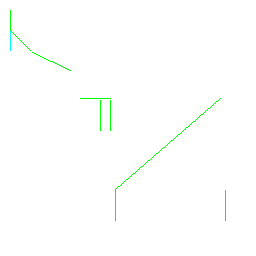

In [6]:
# ori_img = cv2.imread('../static/b1_f.png')
ori_img = cv2.imread('../static/img/self1.png')
# ori_img = ori_img[5000:8000, 5000:7000, :]
Image.fromarray(ori_img)

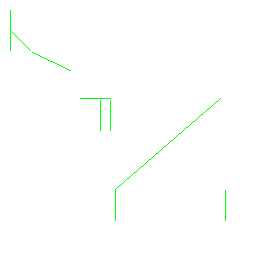

In [7]:
lines, _ = detect_line.detect_lines(ori_img)
white = np.ones_like(ori_img) * 255
for line in lines:
    cv2.line(white, line[0], line[1], line[2], 1)
Image.fromarray(white)

In [9]:
# 连通发现
# 连通发现的条件
"""
【连通条件】
1. 直线端与另一直线端连接
2. 直线端与另一直线中段连接
3. 直线中段与另一直线中段连接
4. 颜色相同
以上这些条件，在不同的使用场景下，可任意选择
【实现流程】：
输入全体直线数据（格式为之前直线检测的输出格式）
对输入的直线进行两两判断，满足相连的定义则建立链接（使用链式前向星）链接关系具有传递性
判断完全部直线组合后，使用并查集将每一组连通域合并。
整理格式，输出。
【效率优化】
输入的直线数量通常比较多，进行两两组合所需要的时间成本极高。
为了减少时间复杂度，可以设计相应的剪枝算法：
对输入数据进行预处理，在坐标系中划分网格，预处理每一条直线所经过的网格。从而两条直线存在链接，当且仅当他们的经过的网格有重叠。
"""

'\n【连通条件】\n1. 直线端与另一直线端连接\n2. 直线端与另一直线中段连接\n3. 直线中段与另一直线中段连接\n4. 颜色相同\n以上这些条件，在不同的使用场景下，可任意选择\n【实现流程】：\n输入全体直线数据（格式为之前直线检测的输出格式）\n对输入的直线进行两两判断，满足相连的定义则建立链接（使用链式前向星）链接关系具有传递性\n判断完全部直线组合后，使用并查集将每一组连通域合并。\n整理格式，输出。\n【效率优化】\n输入的直线数量通常比较多，进行两两组合所需要的时间成本极高。\n为了减少时间复杂度，可以设计相应的剪枝算法：\n对输入数据进行预处理，在坐标系中划分网格，预处理每一条直线所经过的网格。从而两条直线存在链接，当且仅当他们的经过的网格有重叠。\n'

In [10]:
# 预处理
print(len(lines))
lines

10


[[(12, 32), (30, 50), (0, 255, 0)],
 [(10, 10), (10, 50), (0, 255, 0)],
 [(100, 100), (100, 130), (0, 255, 0)],
 [(110, 100), (110, 130), (0, 255, 0)],
 [(115, 189), (115, 220), (0, 255, 0)],
 [(225, 190), (225, 220), (0, 255, 0)],
 [(10, 31), (11, 31), (0, 255, 255)],
 [(32, 52), (70, 70), (0, 255, 0)],
 [(80, 98), (110, 98), (0, 255, 0)],
 [(116, 188), (220, 98), (0, 255, 0)]]

In [39]:
# 计算最大坐标空间
def get_max_coord(lines):
    max_x = 0
    max_y = 0
    for line in lines:
        max_x = max(max_x, line[0][0], line[1][0])
        max_y = max(max_y, line[0][1], line[1][1])
    return max_x, max_y
max_x, max_y = get_max_coord(lines)
max_x, max_y

(225, 220)

In [12]:
# 按照一定尺寸拆分网格
grid_size = 100
def split_grid(max_x, max_y, grid_size):
    grid_x = math.ceil(max_x / grid_size)
    grid_y = math.ceil(max_y / grid_size)
    return grid_x, grid_y
grid_x, grid_y = split_grid(max_x, max_y, grid_size)
grid_x, grid_y

(3, 3)

In [13]:
def line_coord2grids(line, grid_size, grid_x, grid_y):
    i = 0
    """
    line: [(x1, y1), (x2, y2), (r, g, b)]
    grid_size: 每个网格的大小
    grid_x, grid_y: 网格的维度数量
    返回经过的网格坐标集合
    """
    start = line[0]
    end = line[1]
    x0, y0 = start
    x1, y1 = end

    # 将坐标限制在有效范围内，防止越界
    max_x = grid_x * grid_size
    max_y = grid_y * grid_size
    # 使用一个极小的epsilon来避免刚好在边界上导致计算到下一个网格
    epsilon = 1e-9
    x0 = max(0.0, min(x0, max_x - epsilon))
    y0 = max(0.0, min(y0, max_y - epsilon))
    x1 = max(0.0, min(x1, max_x - epsilon))
    y1 = max(0.0, min(y1, max_y - epsilon))

    # 计算初始网格
    i0 = int(x0 // grid_size)
    j0 = int(y0 // grid_size)
    i0 = max(0, min(i0, grid_x - 1))
    j0 = max(0, min(j0, grid_y - 1))

    i1 = int(x1 // grid_size)
    j1 = int(y1 // grid_size)
    i1 = max(0, min(i1, grid_x - 1))
    j1 = max(0, min(j1, grid_y - 1))

    grids = set()
    grids.add((j0, i0))

    dx = x1 - x0
    dy = y1 - y0

    # 处理起点和终点重合的情况
    if dx == 0 and dy == 0:
        return grids

    step_x = 1 if dx > 0 else -1 if dx < 0 else 0
    step_y = 1 if dy > 0 else -1 if dy < 0 else 0

    # 计算初始t_max_x和t_max_y
    if dx != 0:
        if step_x == 1:
            x_next = (i0 + 1) * grid_size
        else:
            x_next = i0 * grid_size
        t_max_x = (x_next - x0) / dx
    else:
        t_max_x = float('inf')

    if dy != 0:
        if step_y == 1:
            y_next = (j0 + 1) * grid_size
        else:
            y_next = j0 * grid_size
        t_max_y = (y_next - y0) / dy
    else:
        t_max_y = float('inf')

    # 计算t_delta_x和t_delta_y
    t_delta_x = (grid_size / abs(dx)) if dx != 0 else float('inf')
    t_delta_y = (grid_size / abs(dy)) if dy != 0 else float('inf')

    current_i, current_j = i0, j0

    while True:
        # 检查是否到达终点网格
        if current_i == i1 and current_j == j1:
            break

        # 决定步进方向
        if t_max_x < t_max_y:
            current_i += step_x
            t_max_x += t_delta_x
        else:
            current_j += step_y
            t_max_y += t_delta_y

        # 确保当前网格在合法范围内
        current_i = max(0, min(current_i, grid_x - 1))
        current_j = max(0, min(current_j, grid_y - 1))

        # 添加当前网格到集合
        grids.add((current_j, current_i))   # 就是反过来的

    return grids

def has_overlap(grids1, grids2):
    """
    判断两个网格集合是否有交集
    """
    return not grids1.isdisjoint(grids2)

grids = line_coord2grids(lines[0], grid_size, grid_x, grid_y)
grids

# mp = np.zeros((grid_y, grid_x))
# for it in grids:
#     mp[it[0], it[1]] = 255
# Image.fromarray(mp).show()
# ####
# white = np.ones_like(ori_img) * 255
# line = lines[0]
# cv2.line(white, line[0], line[1], line[2], 1)
# Image.fromarray(white)

{(0, 0)}

In [14]:
# 进行预处理
def preprocess(lines, grid_size):
    max_x, max_y = get_max_coord(lines)
    grid_x, grid_y = split_grid(max_x, max_y, grid_size)

    grid_dict = {}
    for idx, line in enumerate(lines):
        grids = line_coord2grids(line, grid_size, grid_x, grid_y)
        for grid in grids:
            if grid not in grid_dict:
                grid_dict[grid] = [idx]
            else:
                grid_dict[grid].append(idx)

    return grid_dict
grid_dict = preprocess(lines, grid_size)

In [15]:
# 两两判断连接

# 两点距离判断
def distance(pt1, pt2):
    """
    :param pt1:
    :param pt2:
    :return:
    """
    return math.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

# 点与线段距离判断
def distance_to_line(pt, line):
    """
    计算点到线段的最短距离。

    :param pt: 点 (x0, y0)
    :param line: 线段 [(x1, y1), (x2, y2)]，忽略 (r, g, b) 部分
    :return: 最短距离
    """
    px, py = pt
    x1, y1 = line[0]
    x2, y2 = line[1]
    # 计算线段的方向向量dx, dy
    dx = x2 - x1
    dy = y2 - y1

    # 计算点到线段起点的方向向量
    pdx = px - x1
    pdy = py - y1

    # 投影长度
    t = (pdx * dx + pdy * dy) / (dx * dx + dy * dy)

    if t < 0:  # 超出a点范围
        closest_x = x1
        closest_y = y1
    elif t > 1:  # 超出b点范围
        closest_x = x2
        closest_y = y2
    else:  # 正常情况
        closest_x = x1 + t * dx
        closest_y = y1 + t * dy

    # 计算点到最近点的距离
    distance = math.sqrt((px - closest_x) ** 2 + (py - closest_y) ** 2)
    return distance


# 两直线交叉判断
def is_cross(line1, line2):
    """

    :param line1: [(x1, y1), (x2, y2), (r, g ,b)]
    :param line2: [(x1, y1), (x2, y2), (r, g ,b)]
    :param eps:
    :return:
    """
    x1, y1 = line1[0]
    x2, y2 = line1[1]
    x3, y3 = line2[0]
    x4, y4 = line2[1]
    if (max(x1, x2) >= min(x3, x4) and max(x3, x4) >= min(x1, x2) and
            max(y1, y2) >= min(y3, y4) and max(y3, y4) >= min(y1, y2)):
        if (x1 - x2) * (y3 - y4) - (x3 - x4) * (y1 - y2) == 0:
            return False
        else:
            k1 = (y2 - y1) / (x2 - x1)
            k2 = (y4 - y3) / (x4 - x3)
            b1 = y1 - k1 * x1
            b2 = y3 - k2 * x3
            x = (b2 - b1) / (k1 - k2)
            y = k1 * x + b1
            if (min(x1, x2) <= x <= max(x1, x2) and min(x3, x4) <= x <= max(x3, x4) and
                    min(y1, y2) <= y <= max(y1, y2) and min(y3, y4) <= y <= max(y3, y4)):
                return True
            else:
                return False
    else:
        return False


def check_connect(line1, line2, eps, pattern1, pattern2, pattern3, pattern_color):
    """
    :param line1:
    :param line2:
    :param eps:
    :param pattern1: 1. 直线端与另一直线端连接
    :param pattern2: 2. 直线端与另一直线中段连接 (包含1）
    :param pattern3: 3. 直线中段与另一直线中段连接  (交叉)
    :param pattern_color: 4. 颜色相同
    :return:
    """
    assert not (pattern2 and not pattern1), "pattern2 覆盖 pattern1, 请把pattern1改为True"
    if pattern_color and line1[2] != line2[2]:
        return False
    if pattern3 and is_cross(line1, line2):
        return True
    if pattern2 and (distance_to_line(line1[0], line2)  < eps or
                     distance_to_line(line1[1], line2) < eps or
                     distance_to_line(line2[0], line1) < eps or
                     distance_to_line(line2[1], line1) < eps):
        return True
    if pattern1 and (distance(line1[0], line2[0]) < eps or
                     distance(line1[0], line2[1]) < eps or
                     distance(line1[1], line2[0]) < eps or
                     distance(line1[1], line2[1]) < eps):
        return True
    return False
# check_connect([(0, 0), (1, 1), (0, 0, 0)] , [(1, 1), (2, 2), (0, 0, 0)], 0.1, 0, 0, 1, 1)


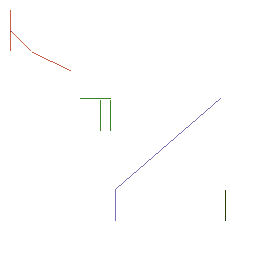

In [38]:
class ChainForwardStar:
    # 链式前向星
    def __init__(self, num_node, num_edge):
        self.num_node = num_node
        self.h = np.ones(num_node, dtype=np.int32) * -1
        self.e = np.zeros(num_edge, dtype=np.int32)
        self.ne = np.zeros(num_edge, dtype=np.int32)
        self.idx = 0

    def add_edge(self, u, v):
        self.e[self.idx] = v
        self.ne[self.idx] = self.h[u]
        self.h[u] = self.idx
        self.idx += 1

    def get_neighbors(self, u):
        neighbors = []
        p = self.h[u]
        while p != -1:
            neighbors.append(self.e[p])
            p = self.ne[p]
        return neighbors

class UnionFind:
    # 并查集
    def __init__(self, size):
        # 初始化每个元素的父节点为自己
        self.parent = list(range(size))
        # 可选：初始化每个集合的元素数量，如果不需要统计集合大小可以省略
        self.rank = [1] * size

    def find(self, x):
        """查找x的根节点，使用路径压缩"""
        if self.parent[x] != x:
            # 路径压缩：将x的父节点设为其根节点的父节点
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        """合并x和y所在的集合"""
        rootX = self.find(x)
        rootY = self.find(y)
        if rootX != rootY:
            # 如果x和y不在同一个集合中，则将较小的集合合并到较大的集合上
            if self.rank[rootX] > self.rank[rootY]:
                self.parent[rootY] = rootX
                self.rank[rootX] += self.rank[rootY]
            else:
                self.parent[rootX] = rootY
                self.rank[rootY] += self.rank[rootX]

    def connected(self, x, y):
        """判断x和y是否在同一集合中"""
        return self.find(x) == self.find(y)

    def get_sets(self):
        """返回并查集中所有连通集合的列表"""
        # 创建一个字典，键是根节点，值是属于该根节点的集合元素列表
        sets_dict = {}
        for i in range(len(self.parent)):
            root = self.find(i)
            if root not in sets_dict:
                sets_dict[root] = []
            sets_dict[root].append(i)

        # 将字典转换为列表
        return list(sets_dict.values())

# 发现连通
def detect_connect(lines, grid_size=100, eps=3):
    grid_dict = preprocess(lines, grid_size)

    num_lines = len(lines)
    cfs = ChainForwardStar(num_lines, num_lines * 10)

    dx = [0, 0, 1, 0, -1]
    dy = [0, -1, 0, 1, 0]
    for key in grid_dict.keys():
        lines_in_grid = []
        for d in zip(dx, dy):
            if (key[0] + d[0], key[1] + d[1]) not in grid_dict:
                continue
            lines_in_grid.extend(grid_dict[(key[0] + d[0], key[1] + d[1])])
            for idx, line1_idx in enumerate(lines_in_grid):
                for jdx, line2_idx in enumerate(lines_in_grid[idx + 1:]):
                    if check_connect(lines[line1_idx], lines[line2_idx], eps, 1, 1, 0, 1) and line1_idx not in cfs.get_neighbors(line2_idx):
                        cfs.add_edge(line1_idx, line2_idx)
                        cfs.add_edge(line2_idx, line1_idx)

    uf = UnionFind(num_lines)
    for i in range(num_lines):
        for j in cfs.get_neighbors(i):
            if uf.connected(i, j):
                continue
            uf.union(i, j)
    sets = uf.get_sets()
    groups = []
    for set_ in sets:
        groups.append([lines[idx] for idx in set_])

    return groups

groups = detect_connect(lines, grid_size=100, eps=3)
white = np.ones_like(ori_img) * 255
for group in groups:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    for line in group:
        cv2.line(white, line[0], line[1], color, 1)
Image.fromarray(white)